In [1]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.utils import shuffle
from sklearn import metrics
from processing.processing import PreProcessing, Analysis
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os
import tweepy

In [2]:
data = PreProcessing.read_davidson_data("data/Davidson&al.csv")
data.tweet = data.tweet.apply(PreProcessing.sanitize_tweet)

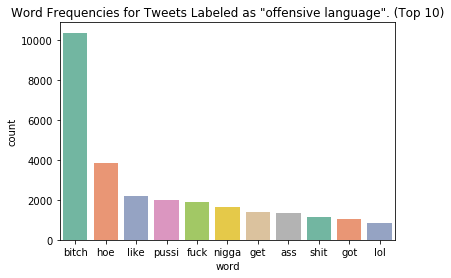

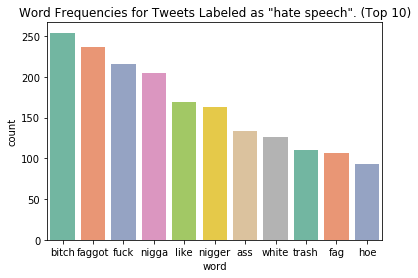

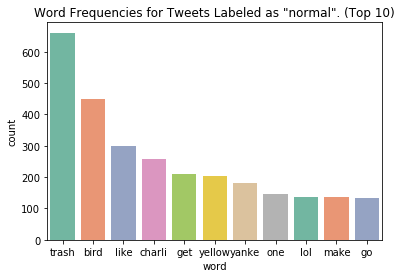

In [3]:
an = Analysis(data)
plt.figure()
an.plot_frequent_words_by_class("offensive language")
plt.figure()
an.plot_frequent_words_by_class("hate speech")
plt.figure()
an.plot_frequent_words_by_class("normal")

Text(0.5, 1.0, 'Data Labels Distribution (Davidson & al.)')

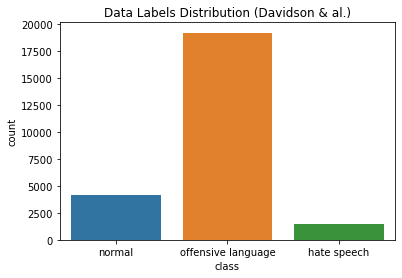

In [4]:
sns.countplot(x="class", data=data).set_title("Data Labels Distribution (Davidson & al.)")

In [5]:
other = PreProcessing.read_waseem_hovy_data("data/Waseem&Hovy.csv")
data = data.append(other)
old_data = data.copy()

Text(0.5, 1.0, 'Data Labels Distribution (Davidson & al. + Waseem & Hovy)')

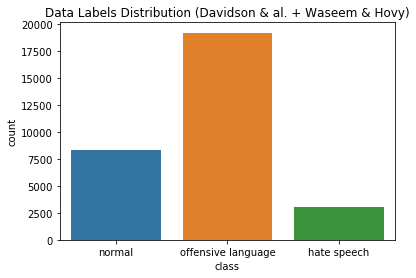

In [6]:
sns.countplot(x="class", data=data).set_title("Data Labels Distribution (Davidson & al. + Waseem & Hovy)")

In [7]:
an = Analysis(data)
stats = an.check_ngrams()

Text(0.5, 1.0, 'Ngrams Impact on Precision (CountVectorizer)')

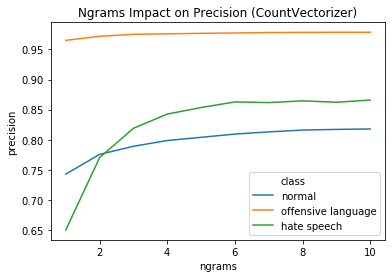

In [14]:
sns.lineplot(data=stats, x="ngrams", y="precision", hue="class").set_title("Ngrams Impact on Precision (CountVectorizer)")

In [9]:
pipe = Pipeline([('count', CountVectorizer(ngram_range=(1, 6))), ('tfidf', TfidfTransformer()), ('clf', SGDClassifier(class_weight="balanced", shuffle=True)), ])
pipe = pipe.fit(data["tweet"], data["class"])

In [10]:
# Gordon Ramsay Insults LUL
docs_new = ["Hey, panini head! Are you listening?", "You're an idiot sandwich", "Fuck off you fat useless sack of fucking yankee dankee doodle shite", "You surprise me as to how bad you are", "Fuck off! Fuck off! Fuck off! Fuck off!", "You guys cook like old people.", "There’s enough garlic in here to kill every vampire in Europe.", "This soufflé has sunk so badly James Cameron wants to make a film about it.", "He can't count to fucking two!", "You deserve a kick in the nuts", "You look like you're just about to lose your virginity.", "You're a fucking disgrace"]
docs_new_sanitized = [PreProcessing.sanitize_tweet(s) for s in docs_new]
predicted = pipe.predict(docs_new_sanitized)
for x,y in zip(docs_new, predicted):
    print(x, "->", y)

Hey, panini head! Are you listening? -> normal
You're an idiot sandwich -> normal
Fuck off you fat useless sack of fucking yankee dankee doodle shite -> offensive language
You surprise me as to how bad you are -> normal
Fuck off! Fuck off! Fuck off! Fuck off! -> offensive language
You guys cook like old people. -> normal
There’s enough garlic in here to kill every vampire in Europe. -> normal
This soufflé has sunk so badly James Cameron wants to make a film about it. -> normal
He can't count to fucking two! -> offensive language
You deserve a kick in the nuts -> normal
You look like you're just about to lose your virginity. -> normal
You're a fucking disgrace -> hate speech


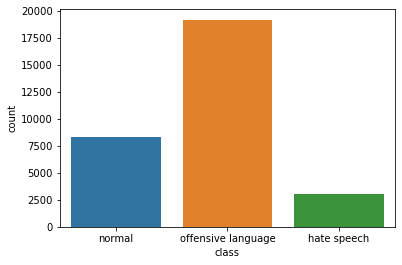

In [11]:
sns.countplot(x="class", data=data)

In [12]:
print(metrics.classification_report(data["class"], pipe.predict(data["tweet"])))

precision    recall  f1-score   support

       hate speech       0.86      0.84      0.85      3004
            normal       0.81      0.98      0.89      8319
offensive language       0.98      0.89      0.93     19190

          accuracy                           0.91     30513
         macro avg       0.88      0.90      0.89     30513
      weighted avg       0.92      0.91      0.91     30513



In [13]:
import pickle
with open("hatespeech_detection.model", "wb") as f:
    pickle.dump(pipe, f)